In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

device = torch.device("cuda")

In [ ]:
"""
This section grabs the SemEval dataset from Dropbox.
Requires a dropbox API key.
"""
import os.path

if not os.path.isfile('semeval.zip'):
  try:
    import dropbox
  except:
    !pip3 install dropbox
    import dropbox

  ACCESS_TOKEN = input("Enter in your access token")
  dbx = dropbox.Dropbox(ACCESS_TOKEN)
  with open("semeval.zip", "wb") as f:
      metadata, res = dbx.files_download(path="/2017_English_final.zip")
      f.write(res.content)

     |████████████████████████████████| 686kB 14.0MB/s 
Enter in your access token8c-q0zJ8pW4AAAAAAAAAAXPKZoMKjZxU4AWb17lAD9WV_gHzV5ZNPRvRTcbILxYJ


In [ ]:
"""
This section processes the data files and loads the data into a dataframe
"""
# unzip data if folder is not present
if not os.path.isdir('semeval'):
  import zipfile
  with zipfile.ZipFile('semeval.zip', 'r') as zip_ref:
      zip_ref.extractall('semeval')

# get all folders with relavent data in them
task_folders = [f'semeval/2017_English_final/GOLD/{folder}'
                for folder in os.listdir('semeval/2017_English_final/GOLD') 
                if os.path.isdir(f'semeval/2017_English_final/GOLD/{folder}')
]

mapping = {'-2': 'negative', '-1': 'negative', '0': 'neutral', '1': 'positive', '2': 'positive'}

# create a generator for SemEval Twitter Data
# the data files are separated by tab and each folder has it's own data format
def parseTwitter(folders):
  for folder in folders:
    for file in [f'{folder}/{f}' for f in os.listdir(folder) if 'twitter' in f]:
      with open(file, 'r') as f:
        for line in f:
          segments = line.rstrip().split('\t')
          if len(segments) < 3:
            continue
          elif 'A' in folder:
            tweet_data = [segments[0], segments[1], ''.join(segments[2:])]
          elif 'B' in folder:
            tweet_data = [segments[0], segments[-2], segments[-1]]
          else:
            tweet_data = [segments[0], mapping[segments[-2]], segments[-1]]
          yield tweet_data

# create a pandas dataframe
df = pd.DataFrame(parseTwitter(task_folders), columns=['TweetId', 'Sentiment', 'Text'])


In [ ]:
# f1 score and compute balanced accuracy
df.groupby(['Sentiment']).agg('count')

,TweetId,Text
Sentiment,,
negative,15550,15550
neutral,37128,37128
off topic,3,3
positive,48796,48796


In [ ]:
df.head()

,TweetId,Sentiment,Text
0,638060586258038784,neutral,05 Beat it - Michael Jackson - Thriller (25th ...
1,638061181823922176,positive,Jay Z joins Instagram with nostalgic tribute t...
2,638083821364244480,neutral,Michael Jackson: Bad 25th Anniversary Edition ...
3,638091450132078593,positive,I liked a @YouTube video http://t.co/AaR3pjp2P...
4,638125563790557184,positive,18th anniv of Princess Diana's death. I still ...


In [ ]:
"""
Clean up data and
Split the input into training set and test set
The data is split as follows
70 % training set, 15% test set, 15% validation set
"""
# eliminate off topic tweets and make categorical
df = df[df.Sentiment != 'off topic']
df.Sentiment = pd.Categorical(df.Sentiment)
df.Sentiment = df.Sentiment.map({'negative': 0, 'neutral': 1, 'positive':2})

train_text, temp_text, train_labels, temp_labels = train_test_split(df['Text'], df['Sentiment'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Sentiment'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
"""
Install CT-Bert from huggingface along with other modules
"""
!pip3 install transformers
from transformers import (
   AutoConfig,
   AutoTokenizer,
   AutoModelForSequenceClassification,
   AdamW
)


     |████████████████████████████████| 1.3MB 12.6MB/s 
     |████████████████████████████████| 890kB 44.4MB/s 
     |████████████████████████████████| 1.1MB 50.4MB/s 
     |████████████████████████████████| 2.9MB 56.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=76eb6414d2bbfd6652d33917c8aa63f7312ae554b03ccfa09218a9cdf41d9fdc
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
"""
Choose the tokenizer from CT-BERT
use v2
"""
model_name = 'digitalepidemiologylab/covid-twitter-bert-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

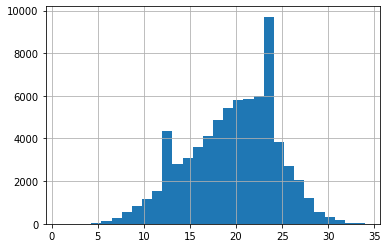

In [ ]:
"""
Display information of the how long each tweet is
"""
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
"""
Use CT-BERT to Tokenize the tweet text for training, test and validation sets
uses the latest API provided by huggingface for text encoding
"""
max_seq_len = 35

train_encodings = tokenizer(
    train_text.tolist(),
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=max_seq_len,
)

val_encodings = tokenizer(
    val_text.tolist(),
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=max_seq_len
)

test_encodings = tokenizer(
    test_text.tolist(),
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=max_seq_len
)

In [ ]:
"""
Use pytorch dataloader to ingest the data and convert to tensors
"""
class SemEvalDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels
  
  def __getitem__(self, idx):
    item = {key: val[idx] for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels.iloc[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = SemEvalDataset(train_encodings, train_labels)
val_dataset = SemEvalDataset(val_encodings, val_labels)
test_dataset = SemEvalDataset(test_encodings, test_labels)

In [ ]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
"""
Training loop to finetune CT Bert to classify sentiment
"""

# declare a model, export to GPU if available and set to training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = AutoModelForSequenceClassification.from_pretrained(
    "digitalepidemiologylab/covid-twitter-bert-v2",
    num_labels = 3
)

model.to(device)
model.train()

# create data loaders based off of training and validation set
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

optim = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 5

# main training loop
for epoch in range(epochs):
  print("")
  print(f'======== Epoch {epoch + 1} / {epochs} ========')
  print('Training...')
  total_train_loss = 0
  t0 = time.time()
  model.train()
    
  # loop through all batches in data loader
  for step, batch in enumerate(train_loader):
    if step % 40 == 0 and not step == 0:
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_loader), elapsed))

    # clear gradient from previous iteration
    optim.zero_grad()
    model.zero_grad()

    # send input encodings, attention mask and labels to GPU
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # feed the batch of data into the model
    loss, logits = model(input_ids, attention_mask=attention_mask, labels=labels)
    total_train_loss += loss.item()

    # clip the norm of the gradients to 1
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    loss.backward()
    optim.step()
    
  # calculate average loss
  avg_train_loss = total_train_loss / len(train_loader) 
  # Measure how long this epoch took.
  training_time = format_time(time.time() - t0)
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))

  print("Running Validation...")
  t0 = time.time()
  model.eval()

  # Tracking variables 
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0
  
  # run performance analysis on validation dataset
  for batch in val_loader:
    # send batch values to gpu
    b_input_ids = batch['input_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
    b_labels = batch['labels'].to(device)

    # feed tata into model without training
    with torch.no_grad():
      loss, logits = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    total_eval_loss += loss.item()
    
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # calculate accuracy on the validation dataset
    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    total_eval_accuracy += np.sum(pred_flat == labels_flat) / len(labels_flat)
  
  # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(val_loader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(val_loader)
    
  # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)
    
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))


Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClass


======== Epoch 1 / 5 ========
Training...
  Batch    40  of  2,220.    Elapsed: 0:00:19.
  Batch    80  of  2,220.    Elapsed: 0:00:38.
  Batch   120  of  2,220.    Elapsed: 0:00:57.
  Batch   160  of  2,220.    Elapsed: 0:01:16.
  Batch   200  of  2,220.    Elapsed: 0:01:35.
  Batch   240  of  2,220.    Elapsed: 0:01:54.
  Batch   280  of  2,220.    Elapsed: 0:02:12.
  Batch   320  of  2,220.    Elapsed: 0:02:31.
  Batch   360  of  2,220.    Elapsed: 0:02:50.
  Batch   400  of  2,220.    Elapsed: 0:03:09.
  Batch   440  of  2,220.    Elapsed: 0:03:28.
  Batch   480  of  2,220.    Elapsed: 0:03:47.
  Batch   520  of  2,220.    Elapsed: 0:04:06.
  Batch   560  of  2,220.    Elapsed: 0:04:25.
  Batch   600  of  2,220.    Elapsed: 0:04:44.
  Batch   640  of  2,220.    Elapsed: 0:05:03.
  Batch   680  of  2,220.    Elapsed: 0:05:22.
  Batch   720  of  2,220.    Elapsed: 0:05:41.
  Batch   760  of  2,220.    Elapsed: 0:06:00.
  Batch   800  of  2,220.    Elapsed: 0:06:19.
  Batch   840  of

In [ ]:
torch.save(model, './sentiment.pt')

In [ ]:
"""
upload model to dropbox in case runtime disconects
"""

try:
    import dropbox
except:
    !pip3 install dropbox
    import dropbox

ACCESS_TOKEN = ""
dbx = dropbox.Dropbox(ACCESS_TOKEN)

def largeUpload(file_path, dest_path):
  with open(file_path, 'rb') as f:
    file_size = os.path.getsize(file_path)
    CHUNK_SIZE = 4 * 1024 * 1024
    upload_session_start_result = dbx.files_upload_session_start(f.read(CHUNK_SIZE))
    cursor = dropbox.files.UploadSessionCursor(session_id=upload_session_start_result.session_id, offset=f.tell())
    commit = dropbox.files.CommitInfo(path=dest_path)

    while f.tell() < file_size:
      if ((file_size - f.tell()) <= CHUNK_SIZE):
        print(dbx.files_upload_session_finish(f.read(CHUNK_SIZE), cursor, commit))
      else:
        dbx.files_upload_session_append(f.read(CHUNK_SIZE), cursor.session_id, cursor.offset)
        cursor.offset = f.tell()
largeUpload('./sentiment.pt', '/sentiment.pt')


FileMetadata(name='sentiment.pt', id='id:YUFk1uYxnEAAAAAAAAAALg', client_modified=datetime.datetime(2020, 11, 18, 8, 54, 55), server_modified=datetime.datetime(2020, 11, 18, 8, 54, 55), rev='015b45dc3e922c60000000179f49db0', size=1340778328, path_lower='/sentiment.pt', path_display='/sentiment.pt', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='843fad090baecb105faf6434b1cc5da44df3af88aa27345e80e331bde6cb6105', file_lock_info=None)


In [ ]:
"""
Load saved model
"""
if not os.path.isfile('./sentiment.pt'):
  with open("sentiment.pt", "wb") as f:
    metadata, res = dbx.files_download(path="/sentiment.pt")
    f.write(res.content)

model = torch.load('./sentiment.pt')


In [ ]:
"""
See how well the model performs on the testing dataset
"""
model.eval()

# Tracking variables 
predictions , actual = np.array([]), np.array([])
loss_data = np.array([])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# Predict 
print("Running Testing...")
t0 = time.time()
  
# run performance analysis on testing dataset
for batch in test_loader:
  # send batch values to gpu
  b_input_ids = batch['input_ids'].to(device)
  b_input_mask = batch['attention_mask'].to(device)
  b_labels = batch['labels'].to(device)

  with torch.no_grad():
    loss, logits = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
  loss_data = np.append(loss_data, loss.item())
    
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # calculate accuracy on the testing dataset
  pred_flat = np.argmax(logits, axis=1).flatten()
  labels_flat = label_ids.flatten()
  predictions = np.append(predictions, pred_flat)
  actual = np. append(actual, labels_flat)
      
# Measure how long the validation run took.
testing_time = format_time(time.time() - t0)

print("  Testing took: {:}".format(testing_time))

Running Testing...
  Testing took: 0:00:58


In [ ]:
# make stuff human readable
lookup = {0: 'negative', 1: 'neutral', 2: 'positive'}
hactual = np.array(list(map(lambda x: lookup[int(x)], actual)))
hpred = np.array(list(map(lambda x: lookup[int(x)], predictions)))

# calculate accuracy
test_acc = np.sum(hactual == hpred) / len(actual)
print("Accuracy: {0:.2f}".format(test_acc))

# plot confusion matrix
y_actu = pd.Series(hactual, name='Actual')
y_pred = pd.Series(hpred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

print(df_confusion)

Accuracy: 0.79
Predicted  negative  neutral  positive
Actual                                
negative       1753      350       229
neutral         455     3465      1650
positive         74      433      6813
